# Forecasting S&P 500 movement

https://quantdare.com/forecasting-sp-500-using-machine-learning/

https://github.com/lcamposgarrido/data-science_projects/blob/b47bc6f69a7f5b69d7675e45ef81770a364ee124/others/stock_predictor/stock_predictor.py#L120


In [172]:
from scipy.stats import mode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")


In [2]:
raw_data_stocks = pd.read_csv("data_stocks.csv")
print(raw_data_stocks.shape)
raw_data_stocks.head(5)

(41266, 502)


,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,NASDAQ.AMAT,NASDAQ.AMD,NASDAQ.AMGN,NASDAQ.AMZN,NASDAQ.ATVI,NASDAQ.AVGO,NASDAQ.BBBY,NASDAQ.BIIB,NASDAQ.CA,NASDAQ.CBOE,NASDAQ.CELG,NASDAQ.CERN,NASDAQ.CHRW,NASDAQ.CHTR,NASDAQ.CINF,NASDAQ.CMCSA,NASDAQ.CME,NASDAQ.COST,NASDAQ.CSCO,NASDAQ.CSX,NASDAQ.CTAS,NASDAQ.CTSH,NASDAQ.CTXS,NASDAQ.DISCA,NASDAQ.DISCK,NASDAQ.DISH,NASDAQ.DLTR,NASDAQ.EA,NASDAQ.EBAY,NASDAQ.EQIX,NASDAQ.ESRX,NASDAQ.ETFC,NASDAQ.EXPD,NASDAQ.EXPE,NASDAQ.FAST,NASDAQ.FB,NASDAQ.FFIV,NASDAQ.FISV,NASDAQ.FITB,NASDAQ.FLIR,NASDAQ.FOX,NASDAQ.FOXA,NASDAQ.GILD,NASDAQ.GOOG,NASDAQ.GOOGL,NASDAQ.GRMN,NASDAQ.GT,NASDAQ.HAS,NASDAQ.HBAN,NASDAQ.HOLX,NASDAQ.HSIC,NASDAQ.IDXX,NASDAQ.ILMN,NASDAQ.INCY,NASDAQ.INFO,NASDAQ.INTC,NASDAQ.INTU,NASDAQ.ISRG,NASDAQ.JBHT,NASDAQ.KHC,NASDAQ.KLAC,NASDAQ.LKQ,NASDAQ.LRCX,NASDAQ.MAR,NASDAQ.MAT,NASDAQ.MCHP,NASDAQ.MDLZ,NASDAQ.MNST,NASDAQ.MSFT,NASDAQ.MU,NASDAQ.MYL,NASDAQ.NAVI,NASDAQ.NDAQ,NASDAQ.NFLX,NASDAQ.NTAP,NASDAQ.NTRS,NASDAQ.NVDA,NASDAQ.NWS,NASDAQ.NWSA,NASDAQ.ORLY,NASDAQ.PAYX,NASDAQ.PBCT,NASDAQ.PCAR,NASDAQ.PCLN,NASDAQ.PDCO,NASDAQ.PYPL,NASDAQ.QCOM,NASDAQ.QRVO,NASDAQ.REGN,NASDAQ.ROST,NASDAQ.SBUX,NASDAQ.SNI,NASDAQ.SNPS,NASDAQ.SPLS,NASDAQ.SRCL,NASDAQ.STX,NASDAQ.SWKS,NASDAQ.SYMC,NASDAQ.TRIP,NASDAQ.TROW,NASDAQ.TSCO,NASDAQ.TXN,NASDAQ.ULTA,NASDAQ.VIAB,NASDAQ.VRSK,NASDAQ.VRSN,NASDAQ.VRTX,NASDAQ.WBA,NASDAQ.WDC,NASDAQ.WFM,NASDAQ.WLTW,NASDAQ.WYNN,NASDAQ.XLNX,NASDAQ.XRAY,NASDAQ.ZION,NYSE.A,NYSE.AAP,NYSE.ABBV,NYSE.ABC,NYSE.ABT,NYSE.ACN,NYSE.ADM,NYSE.ADS,NYSE.AEE,NYSE.AEP,NYSE.AES,NYSE.AET,NYSE.AFL,NYSE.AGN,NYSE.AIG,NYSE.AIV,NYSE.AIZ,NYSE.AJG,NYSE.ALB,NYSE.ALK,NYSE.ALL,NYSE.ALLE,NYSE.AME,NYSE.AMG,NYSE.AMP,NYSE.AMT,NYSE.AN,NYSE.ANTM,NYSE.AON,NYSE.APA,NYSE.APC,NYSE.APD,NYSE.APH,NYSE.ARE,NYSE.ARNC,NYSE.AVB,NYSE.AVY,NYSE.AWK,NYSE.AXP,NYSE.AYI,NYSE.AZO,NYSE.BA,NYSE.BAC,NYSE.BAX,NYSE.BBT,NYSE.BBY,NYSE.BCR,NYSE.BDX,NYSE.BEN,NYSE.BF.B,NYSE.BHI,NYSE.BK,NYSE.BLK,NYSE.BLL,NYSE.BMY,NYSE.BRK.B,NYSE.BSX,NYSE.BWA,NYSE.BXP,NYSE.C,NYSE.CAG,NYSE.CAH,NYSE.CAT,NYSE.CB,NYSE.CBG,NYSE.CBS,NYSE.CCI,NYSE.CCL,NYSE.CF,NYSE.CFG,NYSE.CHD,NYSE.CHK,NYSE.CI,NYSE.CL,NYSE.CLX,NYSE.CMA,NYSE.CMG,NYSE.CMI,NYSE.CMS,NYSE.CNC,NYSE.CNP,NYSE.COF,NYSE.COG,NYSE.COH,NYSE.COL,NYSE.COO,NYSE.COP,NYSE.COTY,NYSE.CPB,NYSE.CRM,NYSE.CSRA,NYSE.CTL,NYSE.CVS,NYSE.CVX,NYSE.CXO,NYSE.D,NYSE.DAL,NYSE.DD,NYSE.DE,NYSE.DFS,NYSE.DG,NYSE.DGX,NYSE.DHI,NYSE.DHR,NYSE.DIS,NYSE.DLPH,NYSE.DLR,NYSE.DOV,NYSE.DOW,NYSE.DPS,NYSE.DRI,NYSE.DTE,NYSE.DUK,NYSE.DVA,NYSE.DVN,NYSE.DXC,NYSE.ECL,NYSE.ED,NYSE.EFX,NYSE.EIX,NYSE.EL,NYSE.EMN,NYSE.EMR,NYSE.EOG,NYSE.EQR,NYSE.EQT,NYSE.ES,NYSE.ESS,NYSE.ETN,NYSE.ETR,NYSE.EVHC,NYSE.EW,NYSE.EXC,NYSE.EXR,NYSE.F,NYSE.FBHS,NYSE.FCX,NYSE.FDX,NYSE.FE,NYSE.FIS,NYSE.FL,NYSE.FLR,NYSE.FLS,NYSE.FMC,NYSE.FRT,NYSE.FTI,NYSE.FTV,NYSE.GD,NYSE.GE,NYSE.GGP,NYSE.GIS,NYSE.GLW,NYSE.GM,NYSE.GPC,NYSE.GPN,NYSE.GPS,NYSE.GS,NYSE.GWW,NYSE.HAL,NYSE.HBI,NYSE.HCA,NYSE.HCN,NYSE.HCP,NYSE.HD,NYSE.HES,NYSE.HIG,NYSE.HOG,NYSE.HON,NYSE.HP,NYSE.HPE,NYSE.HPQ,NYSE.HRB,NYSE.HRL,NYSE.HRS,NYSE.HST,NYSE.HSY,NYSE.HUM,NYSE.IBM,NYSE.ICE,NYSE.IFF,NYSE.IP,NYSE.IPG,NYSE.IR,NYSE.IRM,NYSE.IT,NYSE.ITW,NYSE.IVZ,NYSE.JCI,NYSE.JEC,NYSE.JNJ,NYSE.JNPR,NYSE.JPM,NYSE.JWN,NYSE.K,NYSE.KEY,NYSE.KIM,NYSE.KMB,NYSE.KMI,NYSE.KMX,NYSE.KO,NYSE.KORS,NYSE.KR,NYSE.KSS,NYSE.KSU,NYSE.L,NYSE.LB,NYSE.LEG,NYSE.LEN,NYSE.LH,NYSE.LLL,NYSE.LLY,NYSE.LMT,NYSE.LNC,NYSE.LNT,NYSE.LOW,NYSE.LUK,NYSE.LUV,NYSE.LVLT,NYSE.LYB,NYSE.M,NYSE.MA,NYSE.MAA,NYSE.MAC,NYSE.MAS,NYSE.MCD,NYSE.MCK,NYSE.MCO,NYSE.MDT,NYSE.MET,NYSE.MHK,NYSE.MKC,NYSE.MLM,NYSE.MMC,NYSE.MMM,NYSE.MNK,NYSE.MO,NYSE.MON,NYSE.MOS,NYSE.MPC,NYSE.MRK,NYSE.MRO,NYSE.MS,NYSE.MSI,NYSE.MTB,NYSE.MUR,NYSE.NBL,NYSE.NEE,NYSE.NEM,NYSE.NFX,NYSE.NI,NYSE.NKE,NYSE.NLSN,NYSE.NOC,NYSE.NOV,NYSE.NRG,NYSE.NSC,NYSE.NUE,NYSE.NWL,NYSE.O,NYSE.OKE,NYSE.OMC,NYSE.ORCL,NYSE.OXY,NYSE.PCG,NYSE.PEG,NYSE.PEP,NYSE.PFE,NYSE.PFG,NYSE.PG,NYSE.PGR,NYSE.PH,NYSE.PHM,NYSE.PKI,NYSE.PLD,NYSE.PM,NYSE.PNC,NYSE.PNR,NYSE.PNW,NYSE.PPG,NYSE.PPL,NYSE.PRGO,NYSE.PRU,NYSE.PSA,NYSE.PSX,NYSE.PVH,NYSE.PW

In [3]:
data_stocks = raw_data_stocks.copy()
data_stocks.DATE = pd.to_datetime(data_stocks.DATE, unit='s')
print(data_stocks.DATE.describe()[['count','first', 'last']])
print("du 3 avril 2017 au 31 aout 2017 : ")
print("""
151 jours ouvré = 4 months, 29 days (including the end date)
De 13h30 à 20h 
""")
data_stocks.head()

count                  41266
first    2017-04-03 13:30:00
last     2017-08-31 20:00:00
Name: DATE, dtype: object
du 3 avril 2017 au 31 aout 2017 : 

151 jours ouvré = 4 months, 29 days (including the end date)
De 13h30 à 20h 



,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,NASDAQ.AMAT,NASDAQ.AMD,NASDAQ.AMGN,NASDAQ.AMZN,NASDAQ.ATVI,NASDAQ.AVGO,NASDAQ.BBBY,NASDAQ.BIIB,NASDAQ.CA,NASDAQ.CBOE,NASDAQ.CELG,NASDAQ.CERN,NASDAQ.CHRW,NASDAQ.CHTR,NASDAQ.CINF,NASDAQ.CMCSA,NASDAQ.CME,NASDAQ.COST,NASDAQ.CSCO,NASDAQ.CSX,NASDAQ.CTAS,NASDAQ.CTSH,NASDAQ.CTXS,NASDAQ.DISCA,NASDAQ.DISCK,NASDAQ.DISH,NASDAQ.DLTR,NASDAQ.EA,NASDAQ.EBAY,NASDAQ.EQIX,NASDAQ.ESRX,NASDAQ.ETFC,NASDAQ.EXPD,NASDAQ.EXPE,NASDAQ.FAST,NASDAQ.FB,NASDAQ.FFIV,NASDAQ.FISV,NASDAQ.FITB,NASDAQ.FLIR,NASDAQ.FOX,NASDAQ.FOXA,NASDAQ.GILD,NASDAQ.GOOG,NASDAQ.GOOGL,NASDAQ.GRMN,NASDAQ.GT,NASDAQ.HAS,NASDAQ.HBAN,NASDAQ.HOLX,NASDAQ.HSIC,NASDAQ.IDXX,NASDAQ.ILMN,NASDAQ.INCY,NASDAQ.INFO,NASDAQ.INTC,NASDAQ.INTU,NASDAQ.ISRG,NASDAQ.JBHT,NASDAQ.KHC,NASDAQ.KLAC,NASDAQ.LKQ,NASDAQ.LRCX,NASDAQ.MAR,NASDAQ.MAT,NASDAQ.MCHP,NASDAQ.MDLZ,NASDAQ.MNST,NASDAQ.MSFT,NASDAQ.MU,NASDAQ.MYL,NASDAQ.NAVI,NASDAQ.NDAQ,NASDAQ.NFLX,NASDAQ.NTAP,NASDAQ.NTRS,NASDAQ.NVDA,NASDAQ.NWS,NASDAQ.NWSA,NASDAQ.ORLY,NASDAQ.PAYX,NASDAQ.PBCT,NASDAQ.PCAR,NASDAQ.PCLN,NASDAQ.PDCO,NASDAQ.PYPL,NASDAQ.QCOM,NASDAQ.QRVO,NASDAQ.REGN,NASDAQ.ROST,NASDAQ.SBUX,NASDAQ.SNI,NASDAQ.SNPS,NASDAQ.SPLS,NASDAQ.SRCL,NASDAQ.STX,NASDAQ.SWKS,NASDAQ.SYMC,NASDAQ.TRIP,NASDAQ.TROW,NASDAQ.TSCO,NASDAQ.TXN,NASDAQ.ULTA,NASDAQ.VIAB,NASDAQ.VRSK,NASDAQ.VRSN,NASDAQ.VRTX,NASDAQ.WBA,NASDAQ.WDC,NASDAQ.WFM,NASDAQ.WLTW,NASDAQ.WYNN,NASDAQ.XLNX,NASDAQ.XRAY,NASDAQ.ZION,NYSE.A,NYSE.AAP,NYSE.ABBV,NYSE.ABC,NYSE.ABT,NYSE.ACN,NYSE.ADM,NYSE.ADS,NYSE.AEE,NYSE.AEP,NYSE.AES,NYSE.AET,NYSE.AFL,NYSE.AGN,NYSE.AIG,NYSE.AIV,NYSE.AIZ,NYSE.AJG,NYSE.ALB,NYSE.ALK,NYSE.ALL,NYSE.ALLE,NYSE.AME,NYSE.AMG,NYSE.AMP,NYSE.AMT,NYSE.AN,NYSE.ANTM,NYSE.AON,NYSE.APA,NYSE.APC,NYSE.APD,NYSE.APH,NYSE.ARE,NYSE.ARNC,NYSE.AVB,NYSE.AVY,NYSE.AWK,NYSE.AXP,NYSE.AYI,NYSE.AZO,NYSE.BA,NYSE.BAC,NYSE.BAX,NYSE.BBT,NYSE.BBY,NYSE.BCR,NYSE.BDX,NYSE.BEN,NYSE.BF.B,NYSE.BHI,NYSE.BK,NYSE.BLK,NYSE.BLL,NYSE.BMY,NYSE.BRK.B,NYSE.BSX,NYSE.BWA,NYSE.BXP,NYSE.C,NYSE.CAG,NYSE.CAH,NYSE.CAT,NYSE.CB,NYSE.CBG,NYSE.CBS,NYSE.CCI,NYSE.CCL,NYSE.CF,NYSE.CFG,NYSE.CHD,NYSE.CHK,NYSE.CI,NYSE.CL,NYSE.CLX,NYSE.CMA,NYSE.CMG,NYSE.CMI,NYSE.CMS,NYSE.CNC,NYSE.CNP,NYSE.COF,NYSE.COG,NYSE.COH,NYSE.COL,NYSE.COO,NYSE.COP,NYSE.COTY,NYSE.CPB,NYSE.CRM,NYSE.CSRA,NYSE.CTL,NYSE.CVS,NYSE.CVX,NYSE.CXO,NYSE.D,NYSE.DAL,NYSE.DD,NYSE.DE,NYSE.DFS,NYSE.DG,NYSE.DGX,NYSE.DHI,NYSE.DHR,NYSE.DIS,NYSE.DLPH,NYSE.DLR,NYSE.DOV,NYSE.DOW,NYSE.DPS,NYSE.DRI,NYSE.DTE,NYSE.DUK,NYSE.DVA,NYSE.DVN,NYSE.DXC,NYSE.ECL,NYSE.ED,NYSE.EFX,NYSE.EIX,NYSE.EL,NYSE.EMN,NYSE.EMR,NYSE.EOG,NYSE.EQR,NYSE.EQT,NYSE.ES,NYSE.ESS,NYSE.ETN,NYSE.ETR,NYSE.EVHC,NYSE.EW,NYSE.EXC,NYSE.EXR,NYSE.F,NYSE.FBHS,NYSE.FCX,NYSE.FDX,NYSE.FE,NYSE.FIS,NYSE.FL,NYSE.FLR,NYSE.FLS,NYSE.FMC,NYSE.FRT,NYSE.FTI,NYSE.FTV,NYSE.GD,NYSE.GE,NYSE.GGP,NYSE.GIS,NYSE.GLW,NYSE.GM,NYSE.GPC,NYSE.GPN,NYSE.GPS,NYSE.GS,NYSE.GWW,NYSE.HAL,NYSE.HBI,NYSE.HCA,NYSE.HCN,NYSE.HCP,NYSE.HD,NYSE.HES,NYSE.HIG,NYSE.HOG,NYSE.HON,NYSE.HP,NYSE.HPE,NYSE.HPQ,NYSE.HRB,NYSE.HRL,NYSE.HRS,NYSE.HST,NYSE.HSY,NYSE.HUM,NYSE.IBM,NYSE.ICE,NYSE.IFF,NYSE.IP,NYSE.IPG,NYSE.IR,NYSE.IRM,NYSE.IT,NYSE.ITW,NYSE.IVZ,NYSE.JCI,NYSE.JEC,NYSE.JNJ,NYSE.JNPR,NYSE.JPM,NYSE.JWN,NYSE.K,NYSE.KEY,NYSE.KIM,NYSE.KMB,NYSE.KMI,NYSE.KMX,NYSE.KO,NYSE.KORS,NYSE.KR,NYSE.KSS,NYSE.KSU,NYSE.L,NYSE.LB,NYSE.LEG,NYSE.LEN,NYSE.LH,NYSE.LLL,NYSE.LLY,NYSE.LMT,NYSE.LNC,NYSE.LNT,NYSE.LOW,NYSE.LUK,NYSE.LUV,NYSE.LVLT,NYSE.LYB,NYSE.M,NYSE.MA,NYSE.MAA,NYSE.MAC,NYSE.MAS,NYSE.MCD,NYSE.MCK,NYSE.MCO,NYSE.MDT,NYSE.MET,NYSE.MHK,NYSE.MKC,NYSE.MLM,NYSE.MMC,NYSE.MMM,NYSE.MNK,NYSE.MO,NYSE.MON,NYSE.MOS,NYSE.MPC,NYSE.MRK,NYSE.MRO,NYSE.MS,NYSE.MSI,NYSE.MTB,NYSE.MUR,NYSE.NBL,NYSE.NEE,NYSE.NEM,NYSE.NFX,NYSE.NI,NYSE.NKE,NYSE.NLSN,NYSE.NOC,NYSE.NOV,NYSE.NRG,NYSE.NSC,NYSE.NUE,NYSE.NWL,NYSE.O,NYSE.OKE,NYSE.OMC,NYSE.ORCL,NYSE.OXY,NYSE.PCG,NYSE.PEG,NYSE.PEP,NYSE.PFE,NYSE.PFG,NYSE.PG,NYSE.PGR,NYSE.PH,NYSE.PHM,NYSE.PKI,NYSE.PLD,NYSE.PM,NYSE.PNC,NYSE.PNR,NYSE.PNW,NYSE.PPG,NYSE.PPL,NYSE.PRGO,NYSE.PRU,NYSE.PSA,NYSE.PSX,NYSE.PVH,NYSE.PW

Nombre de jour total :  106


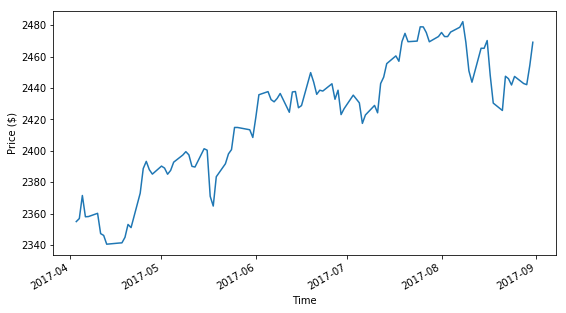

In [142]:
data_stocks['Days'] = pd.to_datetime(data_stocks['DATE'].astype(str).str[:10])
data_stocks['Hours'] = data_stocks['DATE'].astype(str).str[-8:-3]

print("Nombre de jour total : ",data_stocks['Days'].nunique())
plt.figure(figsize=(10,7))
ax = data_stocks.groupby('Days').mean()['SP500'].plot(figsize=(9, 5))
ax.set_ylabel("Price ($)")
ax.set_xlabel("Time")
plt.show()
# Il serait possible de reconstituer l'ouverture la fermeture etc (bougies) sur 106 jours

(41266, 3)


,SP500,Days,Hours
DATE,,,
2017-04-03 13:30:00,2363.6101,2017-04-03,13:30
2017-04-03 13:31:00,2364.1001,2017-04-03,13:31
2017-04-03 13:32:00,2362.6799,2017-04-03,13:32
2017-04-03 13:33:00,2364.3101,2017-04-03,13:33
2017-04-03 13:34:00,2364.8501,2017-04-03,13:34


## Preprocessing
Nous allons ici créer les variables low, high et close

In [160]:
data = data_stocks[['SP500', 'DATE', 'Days', 'Hours']].set_index('DATE')
print(data.shape)
# min max par jour
for day in data.Days.unique():
    data.loc[data.Days == day, "low"] = data[data.Days == day].min()['SP500']
    data.loc[data.Days == day, "high"] = data[data.Days == day].max()['SP500']

# open close par jour
for day in data.Days.unique():
    #data.loc[data.Days == day, "open"] = data[(data.Days == day) & (data.Hours == "13:30")]['SP500']
    sp500 = data[(data.Days == day) & (data.Hours == "20:00")]['SP500']
    if(len(sp500)):
        sp500 = sp500[0]
    elif(len(data[(data.Days == day) & (data.Hours == "17:00")]['SP500'])) : 
        sp500 = data[(data.Days == day) & (data.Hours == "17:00")]['SP500'][0]
    data.loc[data.Days == day, "close"] = sp500

data.describe()

(41266, 3)


,SP500,low,high,close
count,41266.000000,41266.000000,41266.000000,41266.000000
mean,2421.537882,2414.568427,2426.853094,2421.148244
std,39.557135,40.169280,38.998233,39.926296
min,2329.139900,2329.139900,2348.000000,2329.139900
25%,2390.860100,2386.760000,2395.419900,2390.840100
50%,2430.149900,2422.080100,2435.139900,2429.860100
75%,2448.820100,2441.870100,2454.760000,2448.020000
max,2490.649900,2475.950000,2490.649900,2480.600100


In [149]:
def rebalance(unbalanced_data):

    # Separate majority and minority classes
    data_minority = unbalanced_data[unbalanced_data.target==0]
    data_majority = unbalanced_data[unbalanced_data.target==1]

    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=5)

    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])

    data_upsampled.sort_index(inplace=True)

    # Display new class counts
    data_upsampled.target.value_counts()

    return data_upsampled

In [204]:
def normalize(x):

    scaler = StandardScaler()
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)

    return x_norm

In [161]:
def get_indicators(data, n):

    hh = data['high'].rolling(n).max()
    ll = data['low'].rolling(n).min()
    up, dw = data['close'].diff(), -data['close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    macd = data['close'].ewm(12).mean() - data['close'].ewm(26).mean()
    macd_signal = macd.ewm(9).mean()
    tp = (data['high'] + data['low'] + data['close']) / 3
    tp_ma = tp.rolling(n).mean()
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'momentum',
                                       'sto_k','sto_d', 'rsi',
                                       'macd', 'lw_r', 'a/d', 'cci'])
    indicators['sma'] = data['close'].rolling(10).mean()
    indicators['ema'] = data['close'].ewm(10).mean()
    indicators['momentum'] = data['close'] - data['close'].shift(n)
    indicators['sto_k'] = (data['close'] - ll) / (hh - ll) * 100
    indicators['sto_d'] = indicators['sto_k'].rolling(n).mean()
    indicators['rsi'] = 100 - 100 / (1 + up.rolling(14).mean() / dw.rolling(14).mean())
    indicators['macd'] = macd - macd_signal
    indicators['lw_r'] = (hh - data['close']) / (hh - ll) * 100
    indicators['a/d'] = (data['high'] - data['close'].shift()) / (data['high'] - data['low'])
    indicators['cci'] = (tp - tp_ma) / (0.015 * tp.rolling(n).apply(lambda x: np.std(x)))
    direction = (data.close > data.close.shift()).astype(int)
    indicators['target'] = direction.shift(-1).fillna(0).astype(int)
    return indicators


In [186]:
def scores(models, X, y):

    for model in models:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_pred)
        print("Accuracy Score: {0:0.2f} %".format(acc * 100))
        print("F1 Score: {0:0.4f}".format(f1))
        print("Area Under ROC Curve Score: {0:0.4f}".format(auc))

In [208]:
data_days = data.groupby('Days').mean()
print(data_days.shape)
data_train = get_indicators(data_days,10).iloc[20:]
data_train = rebalance(data_train)
y = data_train.target
X = data_train.drop('target', axis=1)
X = normalize(X)
# n'ayant pas assez de données nous ne metterons pas en place d'échantillon de validation 
data_train.isna().sum()

(106, 4)


sma         0
ema         0
momentum    0
sto_k       0
sto_d       0
rsi         0
macd        0
lw_r        0
a/d         0
cci         0
target      0
dtype: int64

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, shuffle=False)
print("train : ",X_train.shape)
print("test : ",X_test.shape)

train :  (28, 10)
test :  (68, 10)


In [210]:
models = [#GaussianNB(),
          SVC(random_state=5),
          RandomForestClassifier(random_state=5),
          #MLPClassifier(random_state=5)
        ]

for model in models:
    model.fit(X_train, y_train)

scores(models, X_test, y_test)

Accuracy Score: 63.24 %
F1 Score: 0.6575
Area Under ROC Curve Score: 0.6307
Accuracy Score: 64.71 %
F1 Score: 0.6667
Area Under ROC Curve Score: 0.6459


In [211]:

# Grid search
grid_data = [[{'kernel': ['poly'], 'degree': [1, 2, 3, 4], 'C': [0.1, 1, 10, 100], 'random_state': [5]},
              {'kernel': ['rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100], 'random_state': [5]}],
              {'n_estimators': [10, 50, 100],
               'criterion': ['gini', 'entropy'],
               'max_depth': [None, 10, 50, 100],
               'min_samples_split': [2, 5, 10],
               'random_state': [5]},
              {'hidden_layer_sizes': [10, 50, 100],
               'activation': ['identity', 'logistic', 'tanh', 'relu'],
               'solver': ['lbfgs', 'sgd', 'adam'],
               'learning_rate': ['constant', 'invscaling', 'adaptive'],
               'max_iter': [200, 400, 800],
               'random_state': [5]}]
models_grid = list()
    
for i in range(len(models)):
    grid = GridSearchCV(models[i], grid_data[i], scoring='f1').fit(X_train, y_train)
    print(grid.best_params_)
    model = grid.best_estimator_
    models_grid.append(model)
scores(models_grid, X_test, y_test)

{'C': 100, 'kernel': 'sigmoid', 'random_state': 5}
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 5}
Accuracy Score: 67.65 %
F1 Score: 0.6333
Area Under ROC Curve Score: 0.6805
Accuracy Score: 57.35 %
F1 Score: 0.6329
Area Under ROC Curve Score: 0.5693


In [212]:
data_days = data.groupby('Days').mean()
print(data_days.shape)
data_val = get_indicators(data_days,10).iloc[20:]
data_val = rebalance(data_train)

y_val = data_val.target
X_val = data_val.drop('target', axis=1)
X_val = normalize(X_val)
X_val

(106, 4)


,sma,ema,momentum,sto_k,sto_d,rsi,macd,lw_r,a/d,cci
Days,,,,,,,,,,
2017-05-02,-1.889553,-1.782732,1.476345,0.869159,0.298229,0.099677,0.498772,-0.869159,0.061128,0.356533
2017-05-03,-1.720504,-1.721293,1.515941,0.607417,0.634417,0.287389,0.487910,-0.607417,-0.950254,0.013762
2017-05-04,-1.606864,-1.661028,0.888945,0.683612,0.695474,0.871883,0.477614,-0.683612,-0.288324,-0.051378
2017-05-05,-1.436184,-1.574329,1.534393,1.308422,0.940622,0.731198,0.543832,-1.308422,0.738562,1.046142
2017-05-05,-1.436184,-1.574329,1.534393,1.308422,0.940622,0.731198,0.543832,-1.308422,0.738562,1.046142
2017-05-05,-1.436184,-1.574329,1.534393,1.308422,0.940622,0.731198,0.543832,-1.308422,0.738562,1.046142
2017-05-08,-1.351863,-1.498474,0.557190,0.925985,0.920859,1.032911,0.572418,-0.925985,-0.396410,1.471203
2017-05-08,-1.351863,-1.498474,0.557190,0.925985,0.920859,1.032911,0.572418,-0.925985,-0.396410,1.471203
2017-05-09,-1.324346,-1.437917,-0.085575,0.176234,0.798690,1.133809,0.554674,-0.176234,-0.084481,1.011592


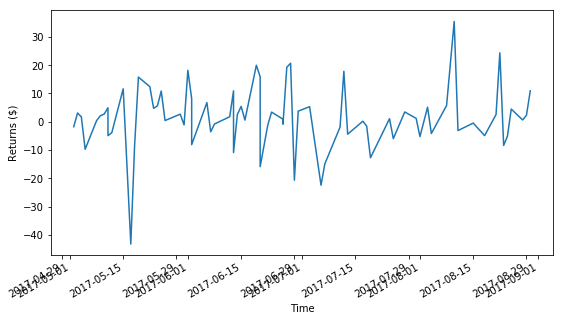

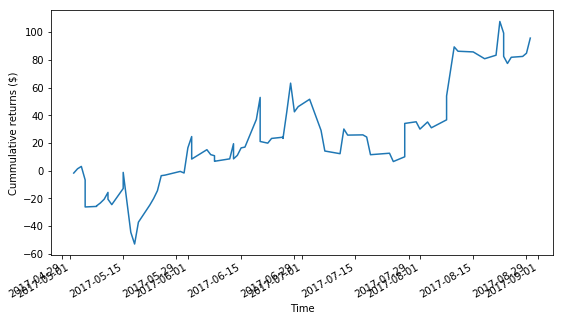

In [214]:


# Trading system - à tester sur le dataset de validation! 
rf_model = models_grid[0]
y_pred = rf_model.predict(X_val)
mask = y_pred.copy()
np.place(mask, y_pred==0, -1)
mask = np.roll(mask, 1)
data_returns = data_days['close'].diff()
data_returns = data_returns[X_val.index]
model_returns = mask * data_returns
model_cum = model_returns.cumsum()
equity = model_returns.sum()
start_close = data_days["close"][X_val.index[0]]
performance = equity / start_close * 100
ax = model_returns.plot(figsize=(9, 5))
ax.set_ylabel("Returns ($)")
ax.set_xlabel("Time")
plt.show()
ax = model_cum.plot(figsize=(9, 5))
ax.set_ylabel("Cummulative returns ($)")
ax.set_xlabel("Time")
plt.show()